<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/introduction-to-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-4-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Supervised Models: Logistic Regression

## What is Logistic Regression

### Classification Problem

As we know there are two types of supervised learning models: those that are used to **predict** a numerical variable and those that are used for **classification**. Up to now we have considered the problem of predicting a numerical variable, we now move on to the classification problem. In particular we focus on the so called Binomial Logistic Regression, where the response variable has two values 0 and 1 or pass and fail or true and false. Multinomial Logistic Regression deals with situations where the response variable can have three or more possible values. 

### Why Logistic, not Linear?

With binary classification, let $x$ be some feature and $y$ be the output which can be either 0 or 1.
The probability that the output is 1 given its input can be represented as:

$$P(y=1 \vert x) $$

If we predict the probability via linear regression, we can state it as:

$$P(y=1 \vert x) = \beta_0 + \beta_1 X$$

Linear regression model can generate the predicted probability as any number ranging from negative to positive infinity, whereas probability of an outcome can only lie between 0< P(x)<1.

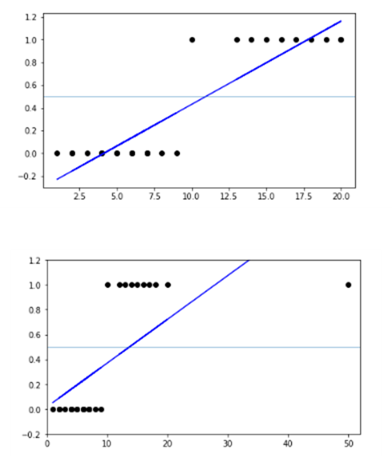

To avoid this problem, log-odds function or logit function is used.

### Logit Function

Logistic regression can be expressed as:

\begin{equation}
\log \left( \frac{p(y=1\vert x)}{1-p(y=1\vert x)}\right) = \beta_0 + \beta_1 X
\end{equation}

where, the left hand side is called the *logit* or *log-odds* function, and $p/(1-p)$ is called *odds*. The odds signifies the ratio of probability of success to probability of failure. Therefore, in Logistic Regression, linear combination of inputs are mapped to the log(odds) - the output being equal to 1. If we take an inverse of the above function, we get:

\begin{equation}
Q=p(y=1 \vert x) = \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}} = \frac{1}{1+e^{-(\beta_0 + \beta_1 X)}} =
\frac{1}{1+e^{-Y}}
\end{equation}

where $Y= \beta_0 + \beta_1 X$. 

This is known as the **Sigmoid Function** and it gives an S-shaped curve. It always gives a value of probability ranging from $0<p<1$.

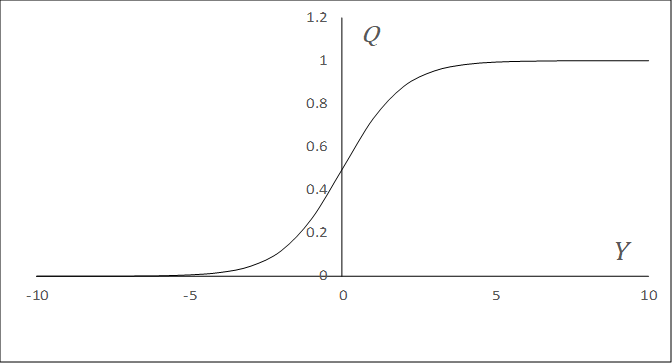

### Estimation of Regression Coefficients

Unlike linear regression model, that uses Ordinary Least Square for parameter estimation, we use Maximum Likelihood Estimation.
There can be infinite sets of regression coefficients. The maximum likelihood estimate is that set of regression coefficients for which the probability of getting the data we have observed is maximum. In this case we can write simply:

\begin{equation}
{\cal{L}} = \prod\limits_{i=1}^n  Q(\mathbf{\beta}^T \mathbf{x})^{y(i)} \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right]^{1-y(i)} \Rightarrow \log{\cal{L}} = 
\sum\limits_{i=1}^n
\left\{
{y(i)} \cdot Q(\mathbf{\beta}^T \mathbf{x}) 
+ (1-y(i)) \cdot \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right] 
\right\}
\end{equation}

Now since in the binomial case $y_i = 1 \,or\, 0$, we can write

\begin{equation}L=\sum\limits_\text{POS OUT} \, \ln(Q) + \sum\limits_\text{NEG OUT} \, \ln(1-Q) \end{equation}

The first summation is over all the observations which led to positive outcomes and the second summation is over all observations which let to negative outcomes. This function cannot be maximized analytically and gradient ascent (analogous to gradient descent) methods must be used.

## Performance of Logistic Regression model

To evaluate the performance of a logistic regression model, Deviance is used in lieu of sum of squares calculations.

- Null Deviance indicates the response predicted by a model with nothing but an intercept.
- Model deviance indicates the response predicted by a model on adding independent variables. If the model deviance is significantly smaller than the null deviance, one can conclude that the parameter or set of parameters significantly improved model fit.
- Another way to find the accuracy of model is by using Confusion Matrix.

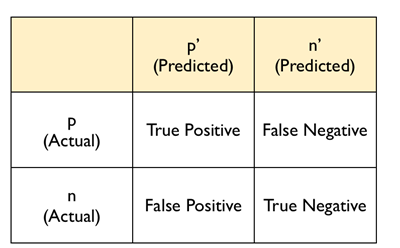

## Application to Credit Decision 

In this section we consider a subset of the data provided by the company Lending Club on its credit decision. For a complete description see the textbook of J. C. Hull chapter 3, pag. 73.

LENDING CLUB BACKGROUND
Lending Club is a peer-to-peer (P2P) lending platform, where borrowers submit their loan applications and individual lenders select the applications that they want to fund. Borrowers receive the full amount of the issued loan minus the origination fee, which is paid to the company. Investors purchase notes backed by the personal loans and pay Lending Club a service fee.

P2P lending brings down the cost of personal loans compared to traditional financing by connecting the borrowers and investors directly. However, there is always a risk of investing in a bad loan. In fact, the default rate for P2P loans are much higher than that of traditional loans. Therefore, the lending industry is highly interested in providing the investors with comprehensive risk assessment of the loan applications. The company shares data about all loan applications made through its platform. 

In [8]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import openpyxl
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [27]:
#
# load file lendingclub_traindata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [28]:
#
# load file lendingclub_testdata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()

In [29]:
train = pd.read_excel(path + 'lendingclub_traindata.xlsx', engine='openpyxl')
test = pd.read_excel(path + 'lendingclub_testdata.xlsx', engine='openpyxl')

In [12]:
# 1 = good, 0 = default

# give column names
cols = ['home_ownership', 'income', 'dti', 'fico_low', 'loan_status']
train.columns = test.columns = cols

print(train.head())
print("--------------------------------")
print(test.head())

   home_ownership  income    dti  fico_low  loan_status
0               1  44.304  18.47       690            0
1               0  38.500  33.73       660            0
2               1  54.000  19.00       660            0
3               1  60.000  33.98       695            0
4               0  39.354  10.85       685            0
--------------------------------
   home_ownership  income    dti  fico_low  loan_status
0               1   127.0  10.94       675            0
1               1   197.0  15.64       710            0
2               1    25.5  28.75       670            0
3               1    80.0  20.16       660            0
4               0    57.0  30.60       675            0


For the purposes of this exercise, the dataset has already been split into train and test set. There are 8695 instances of training set and 5916 instances of test set with with four features and one target. The four features are home_ownership, income, dti and fico_low and the target is loan status that includes either fully paid or defaulted loans only. 

In [13]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# store target column
y_train = train['loan_status']
y_test = test['loan_status']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns

(8695, 4) (8695,) (5916, 4) (5916,)


Index(['home_ownership', 'income', 'dti', 'fico_low'], dtype='object')

By default the mode() method return the highest frequency value in a Series

In [18]:
y_train.mode()[0]

1

In [19]:
majority_class = y_train.mode()[0]        # predict fully paid only
prediction = np.full(shape=y_train.shape, fill_value=majority_class)
accuracy_score(y_train, prediction)

0.8276020701552617

In [20]:
freq = y_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    82.760207
0    17.239793
Name: loan_status, dtype: float64

In [21]:
# create an instance of logistic regression
lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')     
# fit training data on logistic regression 
lgstc_reg.fit(X_train, y_train)                                                             
# get the coefficients of each features
print(lgstc_reg.intercept_, lgstc_reg.coef_)                                                

[-6.56518725] [[ 0.13949599  0.00410667 -0.00112302  0.01125204]]


<br>
The bias is estimated as -6.56517476. The coefficient of the logistic regression are 0.13949599 for home_ownership, 0.0041 0667 for income, -0.00112303 for dti and 0.01125202 for fico_low. These are the weights (parameters) that maximizes the likelihood of producing our given data and hence gives us the least error in predicting our response variable.

The question of how to evaluate the model is of the utmost importance. This is where we will test the model's performance on an unseen test set and check the results of our chosen measure of success. This step is meant to be representative of how the model might perform in the real world.

In [22]:
# predict default loans based on test data set
y_pred = lgstc_reg.predict(X_test)                           

<br> 
An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds. 



In [24]:
THRESHOLD = [.75, .80, .85]
# df to store results
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) 
# threshold column
results['THRESHOLD'] = THRESHOLD                                                                           
             
j = 0                                                                                                      
# iterate over each threshold    
for i in THRESHOLD:     
    # fit data to model
    lgstc_reg.fit(X_train, y_train)
    # if prob > threshold, predict 1
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i, 1, 0)                                       
    # confusion matrix (in percentage)
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / 5916 )*100                   
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]   # True Positives
    FN = cm[0][1]   # False Positives
    FP = cm[1][0]   # True Negatives
    TN = cm[1][1]   # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)  # True negative rate
    results.iloc[j,4] = FP/(FP+TN)  # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS')
print( results.T)
   

Confusion matrix for threshold = 0.75
[[77.5862069   4.5300879 ]
 [16.26098715  1.62271805]]
 
Confusion matrix for threshold = 0.8
[[55.34144692 26.77484787]
 [ 9.75321163  8.13049358]]
 
Confusion matrix for threshold = 0.85
[[28.65111562 53.46517918]
 [ 3.73563218 14.14807302]]
 
ALL METRICS
                   0         1         2
THRESHOLD       0.75       0.8      0.85
accuracy    0.792089  0.634719  0.427992
recall      0.944833   0.67394  0.348909
tnr        0.0907372  0.454631  0.791115
fpr         0.909263  0.545369  0.208885
precision   0.826729  0.850169  0.884656
f1_score    0.881844  0.751866  0.500443


<br>
We note here from the confusion matrix at threshold 0.75 that while the model is good at identifying good loans, however it isn't good at identifying the bad loans at all.

We also note that increasing the threshold results in decrease in overall accuracy. But the percentage of default loans identified as default is higher with increasing threshold. We know by now that maximizing the accuracy does not necessarily create the best model. Thus, lets look at some other metrics.

In [25]:
print( 'ALL METRICS' )
print( results.T )

ALL METRICS
                   0         1         2
THRESHOLD       0.75       0.8      0.85
accuracy    0.792089  0.634719  0.427992
recall      0.944833   0.67394  0.348909
tnr        0.0907372  0.454631  0.791115
fpr         0.909263  0.545369  0.208885
precision   0.826729  0.850169  0.884656
f1_score    0.881844  0.751866  0.500443


0.5
0.6019668412790937


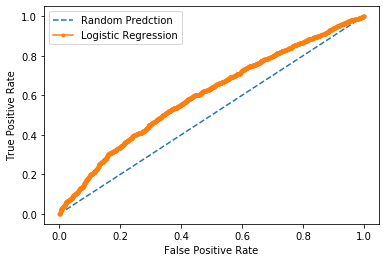

In [26]:
lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]
ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)
print(ns_auc)
print(lr_auc)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<br>
Recall and true negative rate are also decreasing with increase in threshold rate. However, precision and false positive rate are increasing with increasing threshold. 